### Verify CUDA is available for GPU

In [15]:
import torch

if torch.cuda.is_available():
    print("CUDA is available.")
    device_id = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(device_id)
    print(f"CUDA device name: {device_name}")
else:
    print("CUDA is not available.")


CUDA is available.
CUDA device name: NVIDIA GeForce RTX 3070


### Download Data

The dataset used in this project is the **MNIST (Modified National Institute of Standards and Technology) dataset**, which contains **handwritten digits (0-9) in grayscale (28x28 pixels)**.

- The dataset is downloaded from **torchvision.datasets.MNIST**, a PyTorch utility that handles dataset retrieval.
- It is stored in a **binary IDX format**, rather than individual image files (e.g., PNG or JPG).
- The raw dataset is located in `data/MNIST/raw/` and consists of the following files:
    - `train-images-idx3-ubyte` → Training images
    - `train-labels-idx1-ubyte` → Training labels (digits 0-9)
    - `t10k-images-idx3-ubyte` → Test images
    - `t10k-labels-idx1-ubyte` → Test labels

To avoid unnecessary re-downloading, the script checks if these files already exist before downloading them.

In [16]:
import os
from torchvision import datasets, transforms
from PIL import Image

# Define the root data directory
data_root = "../data"

# Define expected MNIST data files
mnist_files = [
    "MNIST/raw/train-images-idx3-ubyte",
    "MNIST/raw/train-labels-idx1-ubyte",
    "MNIST/raw/t10k-images-idx3-ubyte",
    "MNIST/raw/t10k-labels-idx1-ubyte"
]

# Check if MNIST data exists
if all(os.path.exists(os.path.join(data_root, f)) for f in mnist_files):
    print("MNIST dataset already exists. Skipping download.")
else:
    print("Downloading MNIST dataset...")

# Define transformations (convert to tensor)
transform = transforms.Compose([transforms.ToTensor()])

# Load dataset
train_dataset = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

print(f"Train set size: {len(train_dataset)} images")
print(f"Test set size: {len(test_dataset)} images")

MNIST dataset already exists. Skipping download.
Train set size: 60000 images
Test set size: 10000 images


### Print a sample image

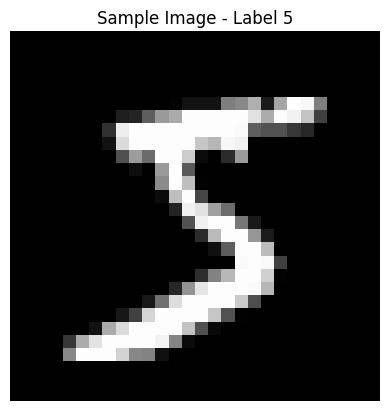

In [17]:
import matplotlib.pyplot as plt
from torchvision import transforms

# Get a single sample image and label
sample_img_tensor, label = train_dataset[0]

# Convert tensor to PIL image in memory
to_pil = transforms.ToPILImage()
sample_img_pil = to_pil(sample_img_tensor)

# Save to ../data/sample.png
sample_img_pil.save("../data/sample.png")

# Display the image
plt.imshow(sample_img_pil, cmap="gray")
plt.title(f"Sample Image - Label {label}")
plt.axis("off")
plt.show()

### Creating Data Loaders

We use PyTorch’s **DataLoader** to efficiently load the MNIST dataset:
- **Batching:** We group images into batches of `64` for faster training.
- **Shuffling:** We shuffle the training data to improve generalization.
- **Parallelization:** Data loading is optimized to speed up processing.

We define:
- `train_loader` → Provides batches for training.
- `test_loader` → Provides batches for testing (without shuffling).

In [18]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 64

# Create DataLoader objects for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the first batch size
images, labels = next(iter(train_loader))
print(f"Batch size: {images.shape}")  # Should be (64, 1, 28, 28)

Batch size: torch.Size([64, 1, 28, 28])


### CNN Model Architecture

We define a convolutional neural network (CNN) to classify MNIST handwritten digits. The architecture includes:

1. **Two convolutional layers** to extract spatial features from images.
2. **ReLU activation functions** to introduce non-linearity.
3. **Max pooling layers** to downsample feature maps.
4. **Fully connected (dense) layers** to classify the extracted features.
5. **Softmax activation** for final classification into 10 digit classes (0-9).

In [19]:
import sys
import os

# Get the absolute path of the project root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add 'model/' to Python's module path
sys.path.append(os.path.join(project_root, "model"))

# Now import CNN
from model import CNN  # Import CNN from model/model.py

# Confirm it works
print("Successfully imported CNN!")

Successfully imported CNN!


### Instantiating the Model

Now, we initialize our CNN model and move it to the **GPU** for faster training if CUDA is available.

In [20]:
# Instantiate the model
model = CNN()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model architecture
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Defining the Loss Function & Optimizer

To train the CNN, we need:
- A **loss function** to measure how well the model is performing.  
  - We use **Negative Log-Likelihood Loss (NLLLoss)**, which is commonly used with `log_softmax()`.  
- An **optimizer** to update model weights during training.  
  - We use **Adam optimizer**, which adapts the learning rate for efficient updates.  

In [21]:
import torch.nn as nn
import torch.optim as optim

# Define loss function
criterion = nn.NLLLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training the CNN

We now train our model using the MNIST dataset.  
Each epoch consists of:
1. **Forward pass:** Compute predictions.
2. **Loss calculation:** Compare predictions to actual labels.
3. **Backward pass:** Compute gradients using backpropagation.
4. **Optimizer step:** Update model weights.

We shuffle training data for randomness and train for **5 epochs**.

In [23]:
import time

# Define number of epochs
epochs = 5

# Track total training time
start_time = time.time()

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    epoch_start_time = time.time()  # Track epoch start time
    
    for images, labels in train_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
    
    # Log epoch duration
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.6f}, Time: {epoch_time:.2f} sec")

# Compute total training time
total_time = time.time() - start_time
print(f"Total Training Time: {total_time:.2f} sec")

Epoch 1/5, Loss: 0.015575, Time: 5.68 sec
Epoch 2/5, Loss: 0.013109, Time: 6.03 sec
Epoch 3/5, Loss: 0.009743, Time: 5.88 sec
Epoch 4/5, Loss: 0.010207, Time: 5.71 sec
Epoch 5/5, Loss: 0.007864, Time: 5.99 sec
Total Training Time: 29.29 sec


### Evaluating the CNN

After training, we assess model performance on unseen test data.
- We **disable gradient calculations** for efficiency.
- We compute **accuracy** to measure classification performance.

In [24]:
# Set model to evaluation mode
model.eval()

# Disable gradient calculations
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        
        # Update metrics
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 99.10%


### Visualizing Model Predictions

Before saving our trained model, we display a few test images along with:
- Their **true labels** (ground truth)
- The **model's predictions**

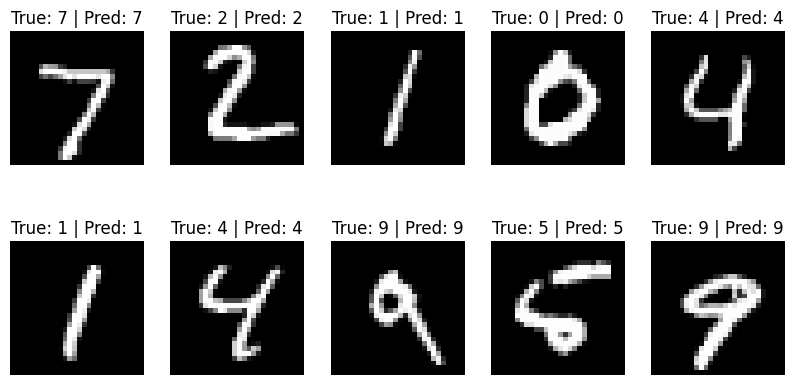

In [25]:
import matplotlib.pyplot as plt

# Get a batch of test images
images, labels = next(iter(test_loader))

# Move to GPU if available
images, labels = images.to(device), labels.to(device)

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)  # Get predicted class

# Plot some images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # Display 10 images (2 rows, 5 columns)
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().squeeze()  # Move to CPU for plotting
    ax.imshow(img, cmap="gray")
    ax.set_title(f"True: {labels[i].item()} | Pred: {predictions[i].item()}")
    ax.axis("off")

plt.show()

### Saving the Entire Model

For deployment, we save the **entire model**, which allows us to:
- Load it later without redefining the architecture.
- Easily integrate it into an inference API.

We use:
- `torch.save(model, PATH)` → Saves the full model.
- `torch.load(PATH)` → Loads the model directly.

In [26]:
# Define the path where the model will be saved
full_model_path = "../model/mnist_cnn_full.pth"

# Ensure the model directory exists
os.makedirs(os.path.dirname(full_model_path), exist_ok=True)

# Save the entire model
torch.save(model, full_model_path)

print(f"Full model saved to {full_model_path}")

Full model saved to ../model/mnist_cnn_full.pth


### Note: Loading the Entire Model

For inference, we directly load the saved `.pth` model using:
- `torch.load(PATH)` → Loads the entire model.
- Moves the model to **GPU (if available)**.
- Sets it to **evaluation mode** (`model.eval()`).

In [27]:
def load_full_model(model_path):
    # Load the full model with weights_only=False
    model = torch.load(model_path, map_location=device, weights_only=False)
    
    # Move model to GPU if available
    model.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    print(f"Full model loaded from {model_path}")
    return model

# Load the saved full model
loaded_full_model = load_full_model(full_model_path)

Full model loaded from ../model/mnist_cnn_full.pth
